We wish to understand the effects of the DFT from a Healpix image onto the UV plane.

I will simulate a fringe on the sky by placing a single pixel in the uv plane, DFT'ing to the sky and then back again onto the uv plane.

We begin with a delta function should end with the Healpix pixel kernel in the UV plane. By varying the Healpix Nside parameter, the effects of the size of the pixel should also manifest in the UV plane.

I will also compute the FFT of the orthographic projection of the same fringe to investigate the Orthographic pixel kernel.

In [ ]:
%matplotlib notebook
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
from astropy.io import fits
from matplotlib.colors import SymLogNorm, LogNorm

filename = "/home/mkolopanis/src/PRISim/prisim/data/beams/HERA_HFSS_X4Y2H_4900.hmap"

In [ ]:
def hpx_to_ortho(map_in, xsize=None):
    """Convert a sky image in Healpix format to an Othrographic projection."""
    nside = hp.get_nside(map_in)
    if xsize is None:
        pix_size = hp.nside2resol(nside)
        xsize = int(np.ceil(np.pi / pix_size))
    R = hp.projector.OrthographicProj(xsize=xsize, half_sky=True, rot=[0, 90.0, 0])
    f = lambda x, y, z: hp.pixelfunc.vec2pix(nside, x, y, z)
    # The projector casts to float, so compute the projection of real and imaginary separately
    ortho_map = np.ma.masked_invalid(R.projmap(map_in.real, f)).astype(np.complex128)
    ortho_map += 1j * np.ma.masked_invalid(R.projmap(map_in.imag, f))
    ortho_map.fill_value = 0
    return ortho_map.filled()

In [ ]:
# Load the HFSS beam simulation of a HERA dish
beam = fits.getdata(filename, "BEAM_X")
freqs = fits.getdata(filename, "FREQS_X")
ind = np.argmin(abs(freqs - 150e6))
beam_150 = beam[:, ind]

<IPython.core.display.Javascript object>


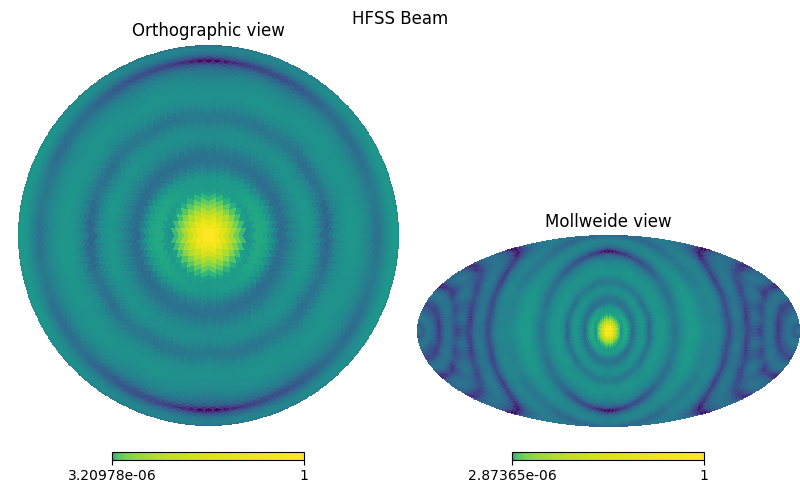

In [ ]:
# Take a quick look at the Beam loaded from the HFSS simulation
figure(figsize=(8, 5))
suptitle("HFSS Beam")
hp.orthview(np.abs(beam_150), rot=[0, 90, 0], norm="log", half_sky=True, sub=121)
hp.mollview(np.abs(beam_150), rot=[0, 90, 0], norm="log", sub=122)

In [ ]:
def simulate_dft(uv_size, nside, uv_delta=0.5):
    # Make a UV plane, add a single pixel, DFT to the sky, then DFT Back
    # Want to check that DFT is being performed correctly and normalization is good.
    #
    # uv_size should be odd
    # uv_delta  in wavelengths

    # create meshgrid of uv pixels
    _range = np.arange(uv_size).astype(np.float64)
    _u, _v = np.meshgrid(_range, _range)
    center = (uv_size - 1) / 2
    # index x and y from -xsize/2 to + xsize/2
    _u -= center
    _v -= center

    # _u and _v should be in wavelengths, pixel index * uv_delta
    _u *= uv_delta
    _v *= uv_delta

    # Place a single pixel in the uv-plane
    baseline_pixel = [10, 0]
    uv_plane = np.zeros_like(_u, dtype=complex)

    # frist index is the vertical in "2d plot land"
    uv_plane[center + baseline_pixel[1], center + baseline_pixel[0]] += 1

    # Create the Simulation at a given NSIDE=64
    # Then the choice of Nside in the function call affects sampling for the DFT
    # Back to the UV plane. We can test if under/over or match sampling affects
    # the kernel.
    # Generate pixel numbers of the healpix sky image above the horizon
    sky = np.zeros(hp.nside2npix(64), dtype=complex)
    _xyz = hp.pix2vec(64, np.arange(sky.size))
    pix_above_horizon = np.where(_xyz[2] >= 0)[0]
    s_ = np.array([_xyz[0], _xyz[1]])  # stack x,y into array

    # Perform the DFT for each sky pixel
    for pix in pix_above_horizon:
        b_dot_s_dft = np.einsum("i...,i", [_u, _v], s_.T[pix])
        sky[pix] = np.sum(uv_plane * np.exp(2j * np.pi * b_dot_s_dft))

    sky = hp.ud_grade(sky, nside_out=nside)
    _xyz = hp.pix2vec(nside, np.arange(sky.size))
    pix_above_horizon = np.where(_xyz[2] >= 0)[0]
    s_ = np.array([_xyz[0], _xyz[1]])  # stack x,y into array

    # DFT back to the UV plane
    new_uv_plane = np.zeros_like(uv_plane, dtype=complex)
    for cnt in range(_u.ravel().size):
        __u, __v = _u.ravel()[cnt], _v.ravel()[cnt]
        b_dot_s_idft = np.einsum("i,i...", [__u, __v], s_)
        new_uv_plane.ravel()[cnt] = np.mean(
            sky[pix_above_horizon]
            * np.exp(-2j * np.pi * b_dot_s_idft[pix_above_horizon])
        )

    return _u, uv_plane, sky, new_uv_plane

To explore the effects of the DFT and the Healpix pixel on a delta function in the uv plane,
set a fixed extent and pixel size in the uv plane, and place a delta function at u,v = 10,0.

The DFT will be computed between this delta function in the UV plane, and 3 sky images with different Healpix Nside parameters (nside=32, 64, and 128). 

The inverse DFT between these 3 images and the uv plane is then stored in a new array indexed by the nside of they sky image.

In [32]:
u_32, uv_32, sky_32, new_uv_32 = simulate_dft(201, 32)

In [33]:
u_64, uv_64, sky_64, new_uv_64 = simulate_dft(201, 64)

In [34]:
u_128, uv_128, sky_128, new_uv_128 = simulate_dft(201, 128)

We will also project all three sky images into orthographic plane, and perform a FFT to calculate the beam in the UV plane.

This secondary estimate of the beam in the UV plane can be used to estimate the fidelity of both types of transforms and the compounding of both the kernels from the transforms and the healpix pixels in the UV plane.

In [36]:
sky_ortho_32 = hpx_to_ortho(sky_32, xsize=201)
uv_from_ortho_32 = np.fft.fftshift( np.fft.ifft2(sky_ortho_32, axes=[0,1]))

In [37]:
sky_ortho_64 = hpx_to_ortho(sky_64, xsize=201)
uv_from_ortho_64 = np.fft.fftshift( np.fft.ifft2(sky_ortho_64, axes=[0,1]))

In [38]:
sky_ortho_128 = hpx_to_ortho(sky_128, xsize=201)
uv_from_ortho_128 = np.fft.fftshift( np.fft.ifft2(sky_ortho_128, axes=[0,1]))

A quick look at the Delta functions in the UV plane again:

<IPython.core.display.Javascript object>


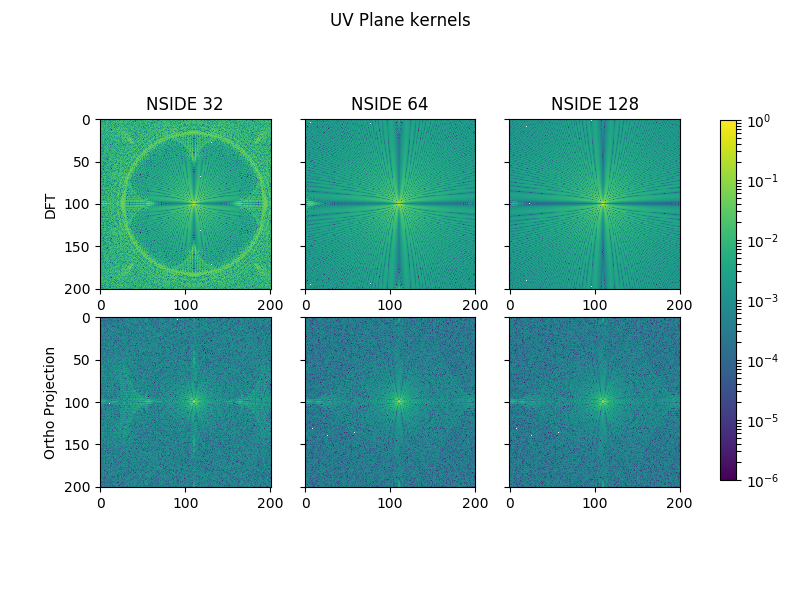

In [ ]:
fig, axes = subplots(ncols=3, nrows=2, figsize=(8, 6))
im = axes[0, 0].imshow(np.abs(new_uv_32), norm=LogNorm(vmax=1, vmin=1e-6))
axes[0, 0].set_title("NSIDE 32")
axes[0, 0].set_ylabel("DFT")
axes[0, 1].imshow(np.abs(new_uv_64), norm=LogNorm(vmax=1, vmin=1e-6))
axes[0, 1].set_title("NSIDE 64")
axes[0, 2].imshow(np.abs(new_uv_128), norm=LogNorm(vmax=1, vmin=1e-6))
axes[0, 2].set_title("NSIDE 128")

axes[1, 0].imshow(np.abs(uv_from_ortho_32), norm=LogNorm(vmax=1, vmin=1e-6))
axes[1, 0].set_ylabel("Ortho Projection")
axes[1, 1].imshow(np.abs(uv_from_ortho_64), norm=LogNorm(vmax=1, vmin=1e-6))
axes[1, 2].imshow(np.abs(uv_from_ortho_128), norm=LogNorm(vmax=1, vmin=1e-6))
for i in range(1, len(axes[0])):
    setp(axes[0, i].get_yticklabels(), visible=False)
    setp(axes[1, i].get_yticklabels(), visible=False)
#     setp(axes[i].get_xticklabels(), visible=False)
fig.subplots_adjust(right=0.85, hspace=-0.25)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle("UV Plane kernels")

A slice of these kernels across v=0, the delta function should exist at u=5 in these slices ( pixel 10 with a uv_delta=.5)

All sky simualtions created with nside=64, before the DFT is computed to the UV-plane,
the simulated sky image is up/down-sampled to the Nside listed on the ylabel.


<IPython.core.display.Javascript object>


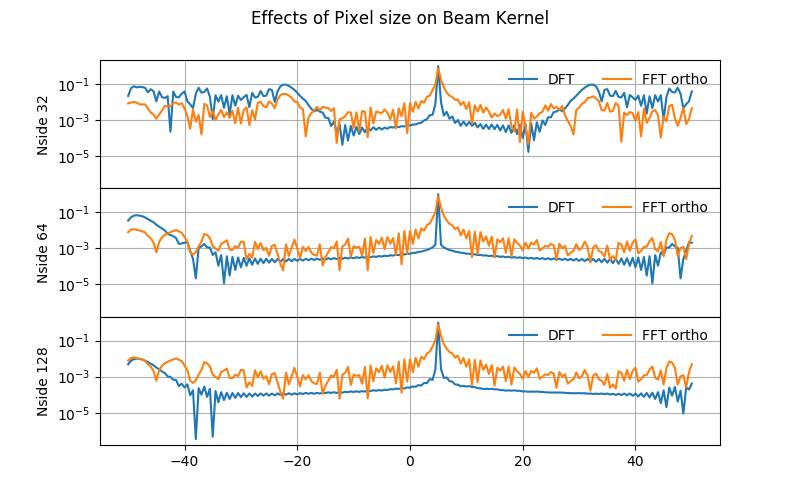

In [ ]:
print(
    "All sky simualtions created with nside=64, before the DFT is computed to the UV-plane,"
)
print("the simulated sky image is up/down-sampled to the Nside listed on the ylabel.")
center = 100
fig, ax = subplots(figsize=(8, 5), nrows=3, sharex=True, sharey=True)
ax[0].plot(u_32[:, 0], np.abs(new_uv_32[center]), label="DFT")
ax[0].plot(u_32[:, 0], np.abs(uv_from_ortho_32[center]), label="FFT ortho")
ax[0].set_ylabel("Nside 32")
ax[1].plot(u_64[:, 0], np.abs(new_uv_64[center]), label="DFT")
ax[1].plot(u_64[:, 0], np.abs(uv_from_ortho_64[center]), label="FFT ortho")
ax[1].set_ylabel("Nside 64")
ax[2].plot(u_128[:, 0], np.abs(new_uv_128[center]), label="DFT")
ax[2].plot(u_128[:, 0], np.abs(uv_from_ortho_128[center]), label="FFT ortho")
ax[2].set_ylabel("Nside 128")
yscale("log")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend(frameon=False, ncol=2, loc="upper right")
fig.subplots_adjust(hspace=0)
suptitle("Effects of Pixel size on Beam Kernel")

The DFT (in blue) of the sky image has a sharper peak that the use of the FFT and orthographic projection (orange); however the sidelobes do appear more prominent. Before hitting the first sidelobe, the DFT power is lower, and less noisy than the FFT'd orthographic projection for all three Healpix arrays.

Undersampling a sky image (Labeled: "Nside 32") forces the pixel shape of the lower resolution map onto the 
gridding kernel, while both match and over sampling (Labeled: "Nside 64" and "Nside 128" respectively) show
sidelobe power in the uv plane at the intrinsic resolution of the simulated image.

By eye, the sidelobes of the nside 32 and fft ortho 32 kernels appear to be approximately 27 wavelengths away from the peak and the nside=64 sky image appears 53 wavelengths away from the peak.

Let's calculate the Healpix pixel size in wavelengths and compare:

In [ ]:
# 1./ pixel resolution in radians should give size in wavelengths
print("Nside 32:", 1.0 / hp.nside2resol(32))
print("Nside 64:", 1.0 / hp.nside2resol(64))

Nside 32: 31.2705607618
Nside 64: 62.5411215236


In [ ]:
# By splitting at the peak (u = 5 wavelengths) and finding the max,
# we can locate the position of the sidelobes
ind1 = np.argmax(np.abs(new_uv_32)[center, center + 12 :])
ind2 = np.argmax(np.abs(new_uv_32)[center, : center + 8])

print(u_32[center + ind1 + 12, 0] - 5, np.abs(new_uv_32)[center, center + 12 + ind1])
print(5 - u_32[ind2, 0], np.abs(new_uv_32)[center, ind2])

27.0 0.0956706403109
27.0 0.0956706403109


In [ ]:
# the by eye estimates were close for the nside=32 case
# let's calculate the percent difference in our estimate and healpix resolution
print("Nside 32:", (1.0 / hp.nside2resol(32) - 27) * hp.nside2resol(32))
print("Nside 64:", (1.0 / hp.nside2resol(64) - 53) * hp.nside2resol(64))

Nside 32: 0.13656809017
Nside 64: 0.152557569982


For the two Nside values who have sidelobes inside the UV grid, the sidelobs appear near the value (.85 * Healpix pixel size) in wavelengths. 

We can use this information in two ways:
```
-Calculate the DFT of the beam only on grid with up to +/- (Healpix pixel size) /2
-Attempt to deconvolve the Healpix pixel window from the beam in the UV plane
```
The first option is an easier computation to complete, even with large Nside. The second, while a **perfect** result would be preferable, is more computationally difficult, and use of an FFT deconvolution could introduce *additional* artifacts.